In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [93]:
df_full_data = pd.read_excel("Synthetic_big.xlsx")

In [94]:
df_full_data.head()

,Unnamed: 0,Titer [tex],avg .circumference [mm],fiber length [mm],fiber tenacity [MPa],W_q [µm],W_Sm [µm],expected concrete compression strength 95% rH [MPa],IFSS [MPa],Minibeam energy absorption (m.e.a.) 0-11 [J],fiber failure mode in beam
0,0,500,3.150,40,450,0.0,0,25,6.834268,2695.440773,1
1,1,532,3.730,40,422,19.5,1276,25,5.818266,3076.427315,1
2,2,540,4.220,40,327,20.9,1230,25,5.425861,2297.532484,1
3,3,500,3.730,40,410,13.7,1243,25,5.811491,3229.171169,1
4,4,500,3.399,40,422,16.1,1324,25,6.649346,3517.499658,1


In [95]:
nan_rows = df_full_data.isna().any()
df_full_data = df_full_data.drop('Unnamed: 0', axis = "columns")
print(nan_rows)

Unnamed: 0                                             False
Titer [tex]                                            False
avg .circumference [mm]                                False
fiber length [mm]                                      False
fiber tenacity [MPa]                                   False
W_q [µm]                                               False
W_Sm [µm]                                              False
expected concrete compression strength 95% rH [MPa]    False
IFSS [MPa]                                             False
Minibeam energy absorption (m.e.a.) 0-11 [J]           False
fiber failure mode in beam                             False
dtype: bool


In [96]:
print(f"The dataset has {len(df_full_data)} rows and {len(df_full_data.columns)} columns.")

The dataset has 1440 rows and 10 columns.


The dataset overall is very clean. The dataset features 1440 rows of 11 columns, one of which can be immediatly dropped because it is an artifact from the indexing within the excel sheet. The remaining 10 columns can be split into 9 columns which we can use to predict the dependent variable "fiber failure mode in beam".  

In [97]:
profile_area = []
for i in range(len(df_full_data)):
    if df_full_data["W_q [µm]"][i] != 0:
        profile_area.append(df_full_data["W_Sm [µm]"][i]/df_full_data["W_q [µm]"][i])
    else:
        profile_area.append(df_full_data["W_Sm [µm]"][i])
df_full_data_extended = df_full_data.assign(profile_area = profile_area)

In a first step, we create the "profile_area" variable, which is an aggregate from "W_Sm" and "W_q". This new variable was created on the basis of common industry standards, where the profile area of the fiber is used as a measure instead of the underlying variables.

In [98]:
df_full_data_extended.head()

,Titer [tex],avg .circumference [mm],fiber length [mm],fiber tenacity [MPa],W_q [µm],W_Sm [µm],expected concrete compression strength 95% rH [MPa],IFSS [MPa],Minibeam energy absorption (m.e.a.) 0-11 [J],fiber failure mode in beam,profile_area
0,500,3.150,40,450,0.0,0,25,6.834268,2695.440773,1,0.000000
1,532,3.730,40,422,19.5,1276,25,5.818266,3076.427315,1,65.435897
2,540,4.220,40,327,20.9,1230,25,5.425861,2297.532484,1,58.851675
3,500,3.730,40,410,13.7,1243,25,5.811491,3229.171169,1,90.729927
4,500,3.399,40,422,16.1,1324,25,6.649346,3517.499658,1,82.236025


E:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


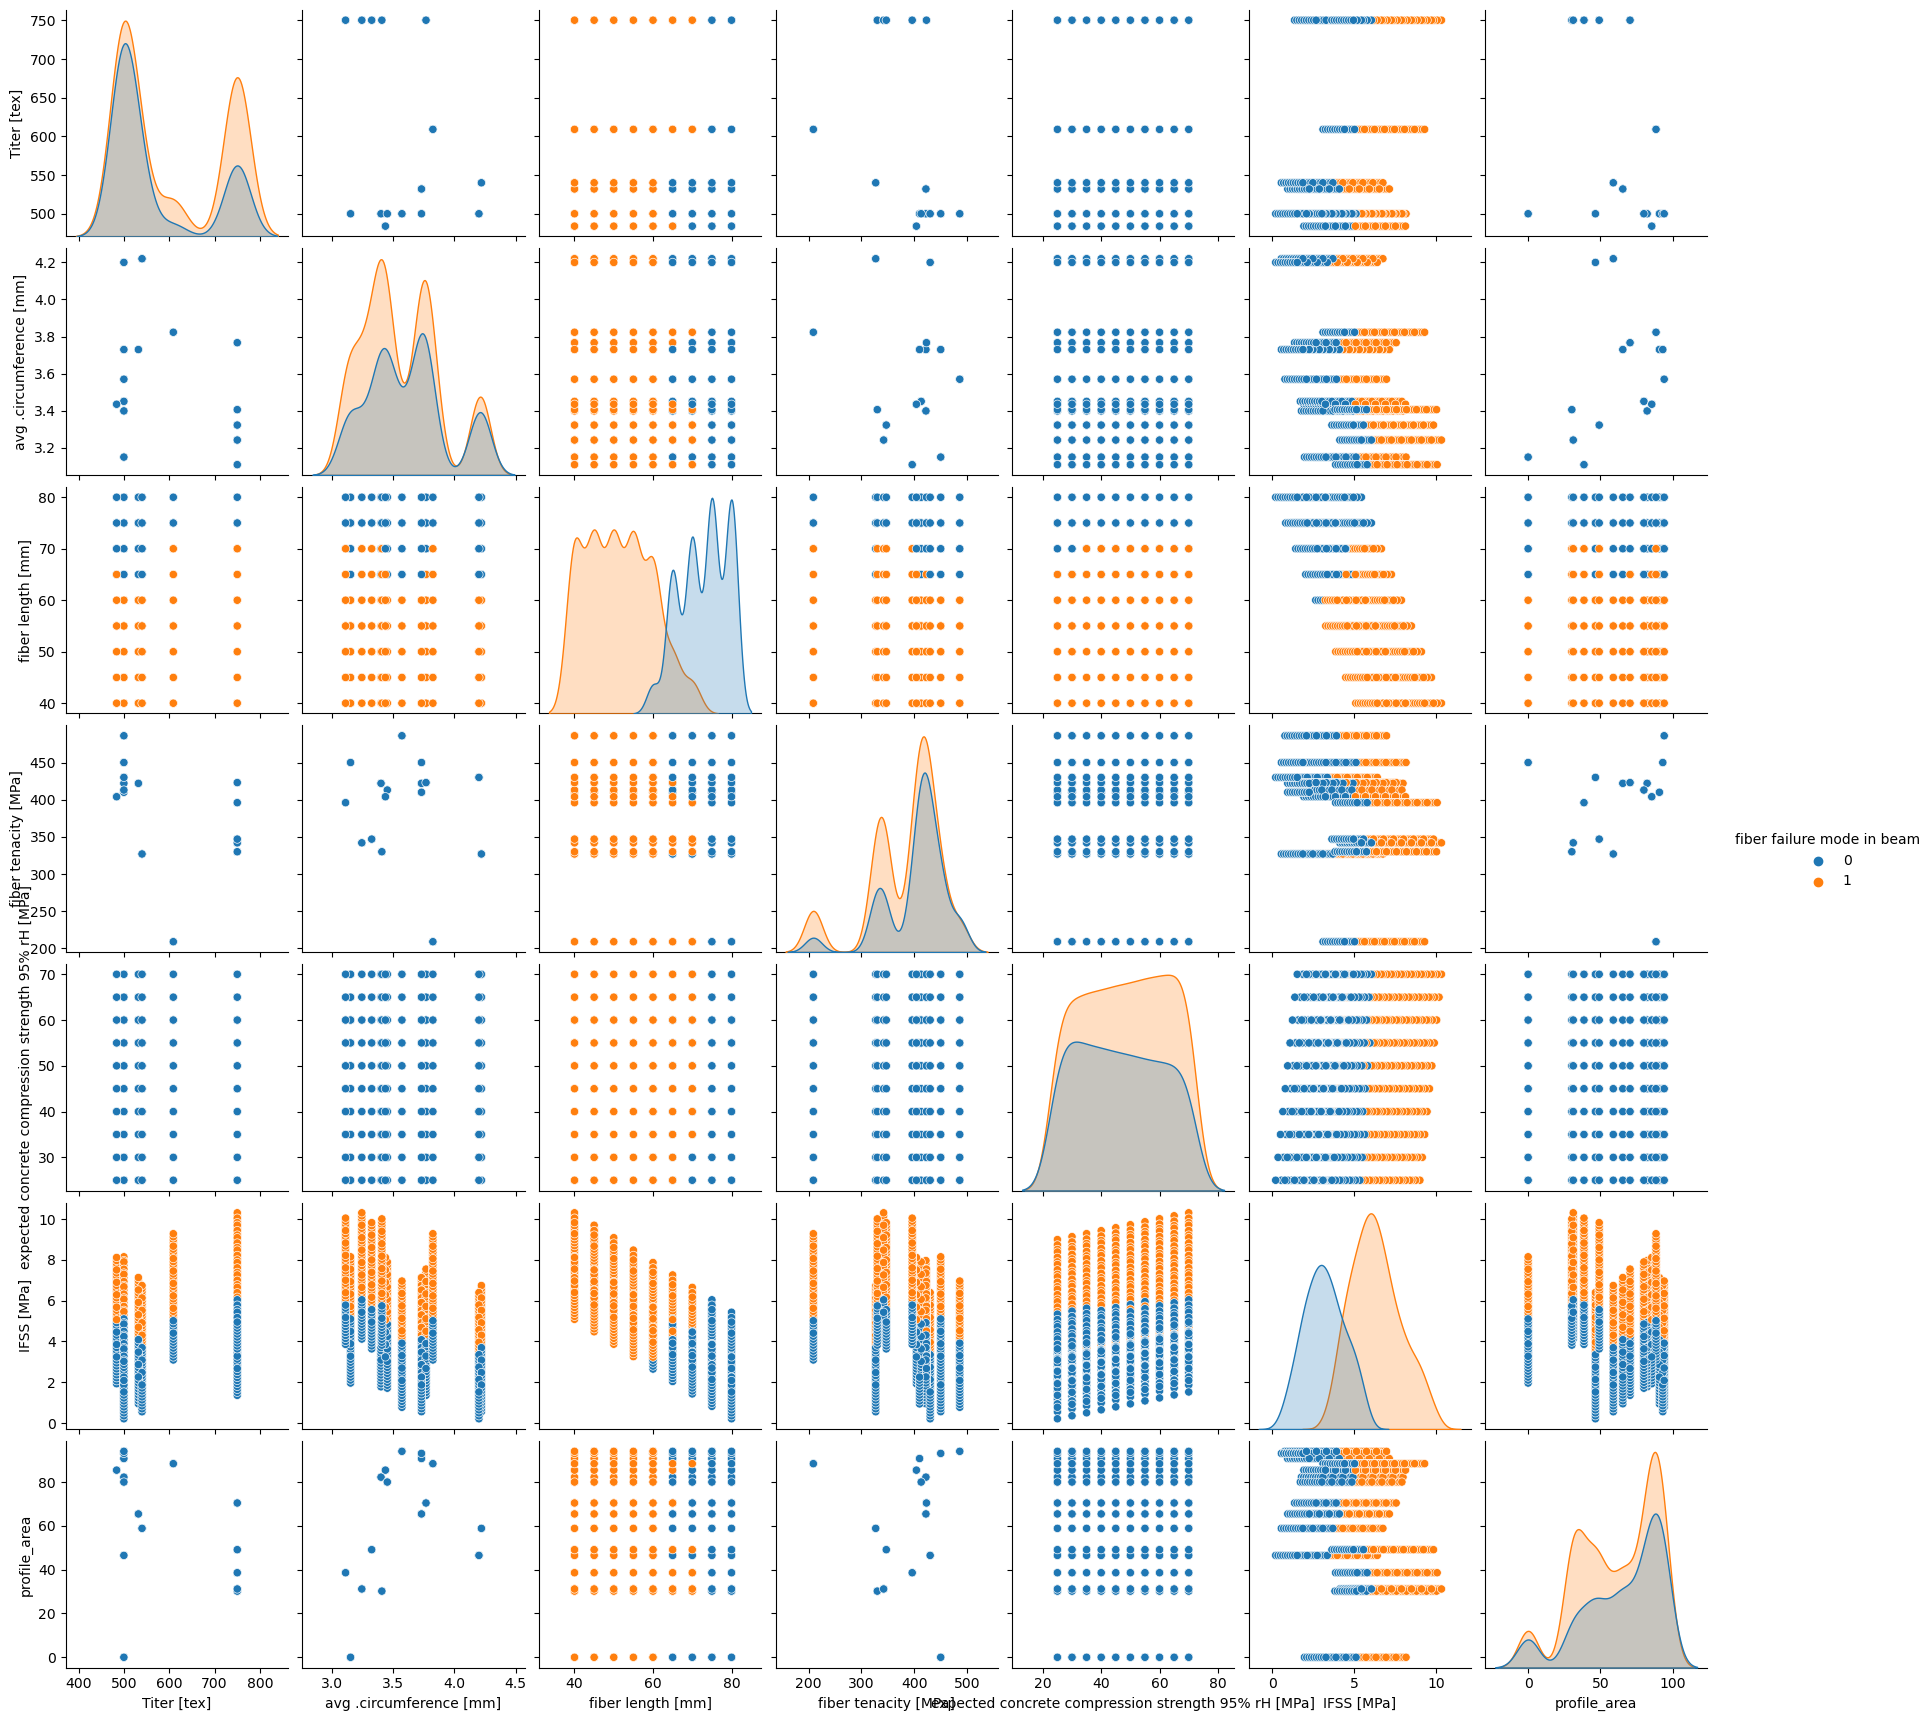

In [54]:
#sns.pairplot(df_full_data_extended, vars = df_full_data_extended.columns[[0,1,2,3,6,7,10]], hue = 'fiber failure mode in beam')

A pairsplot utilizing the predictive variables can grant first insights into the overarching structure of the data. 

In [99]:
df_full_data_extended.describe()

,Titer [tex],avg .circumference [mm],fiber length [mm],fiber tenacity [MPa],W_q [µm],W_Sm [µm],expected concrete compression strength 95% rH [MPa],IFSS [MPa],Minibeam energy absorption (m.e.a.) 0-11 [J],fiber failure mode in beam,profile_area
count,1440.00000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,588.43750,3.580272,60.000000,391.312500,32.181250,1743.375000,47.500000,5.044361,8874.686496,0.597917,62.762341
std,112.43398,0.320642,12.914429,64.621899,23.812976,788.812373,14.366396,2.080503,3564.398554,0.490489,26.976919
min,484.00000,3.109090,40.000000,209.000000,0.000000,0.000000,25.000000,0.206434,1671.000000,0.000000,0.000000
25%,500.00000,3.379921,50.000000,345.750000,15.925000,1267.750000,35.000000,3.482532,5905.008432,0.000000,44.528641
50%,516.00000,3.510250,60.000000,411.500000,21.900000,1723.500000,47.500000,5.036830,8875.005748,1.000000,67.934295
75%,750.00000,3.739250,70.000000,424.750000,47.475000,2175.250000,60.000000,6.493092,11839.311993,1.000000,86.169346
max,750.00000,4.220000,80.000000,486.000000,83.000000,3860.000000,70.000000,10.305632,16937.625582,1.000000,94.017094


In [103]:
df_z_score = df_full_data_extended.apply(stats.zscore)
outliers_higher = df_z_score.ge(3).any()
outliers_lower = df_z_score.le(-3).any()
print(outliers_higher, outliers_lower)

Titer [tex]                                            False
avg .circumference [mm]                                False
fiber length [mm]                                      False
fiber tenacity [MPa]                                   False
W_q [µm]                                               False
W_Sm [µm]                                              False
expected concrete compression strength 95% rH [MPa]    False
IFSS [MPa]                                             False
Minibeam energy absorption (m.e.a.) 0-11 [J]           False
fiber failure mode in beam                             False
profile_area                                           False
dtype: bool Titer [tex]                                            False
avg .circumference [mm]                                False
fiber length [mm]                                      False
fiber tenacity [MPa]                                   False
W_q [µm]                                               False
W_Sm [µm]   

There are no values with a Z-score larger than 3 or smaller than -3, leading to the conclusion that there are no significant outliers within the dataset.

Histogramms of the Predictive Variables

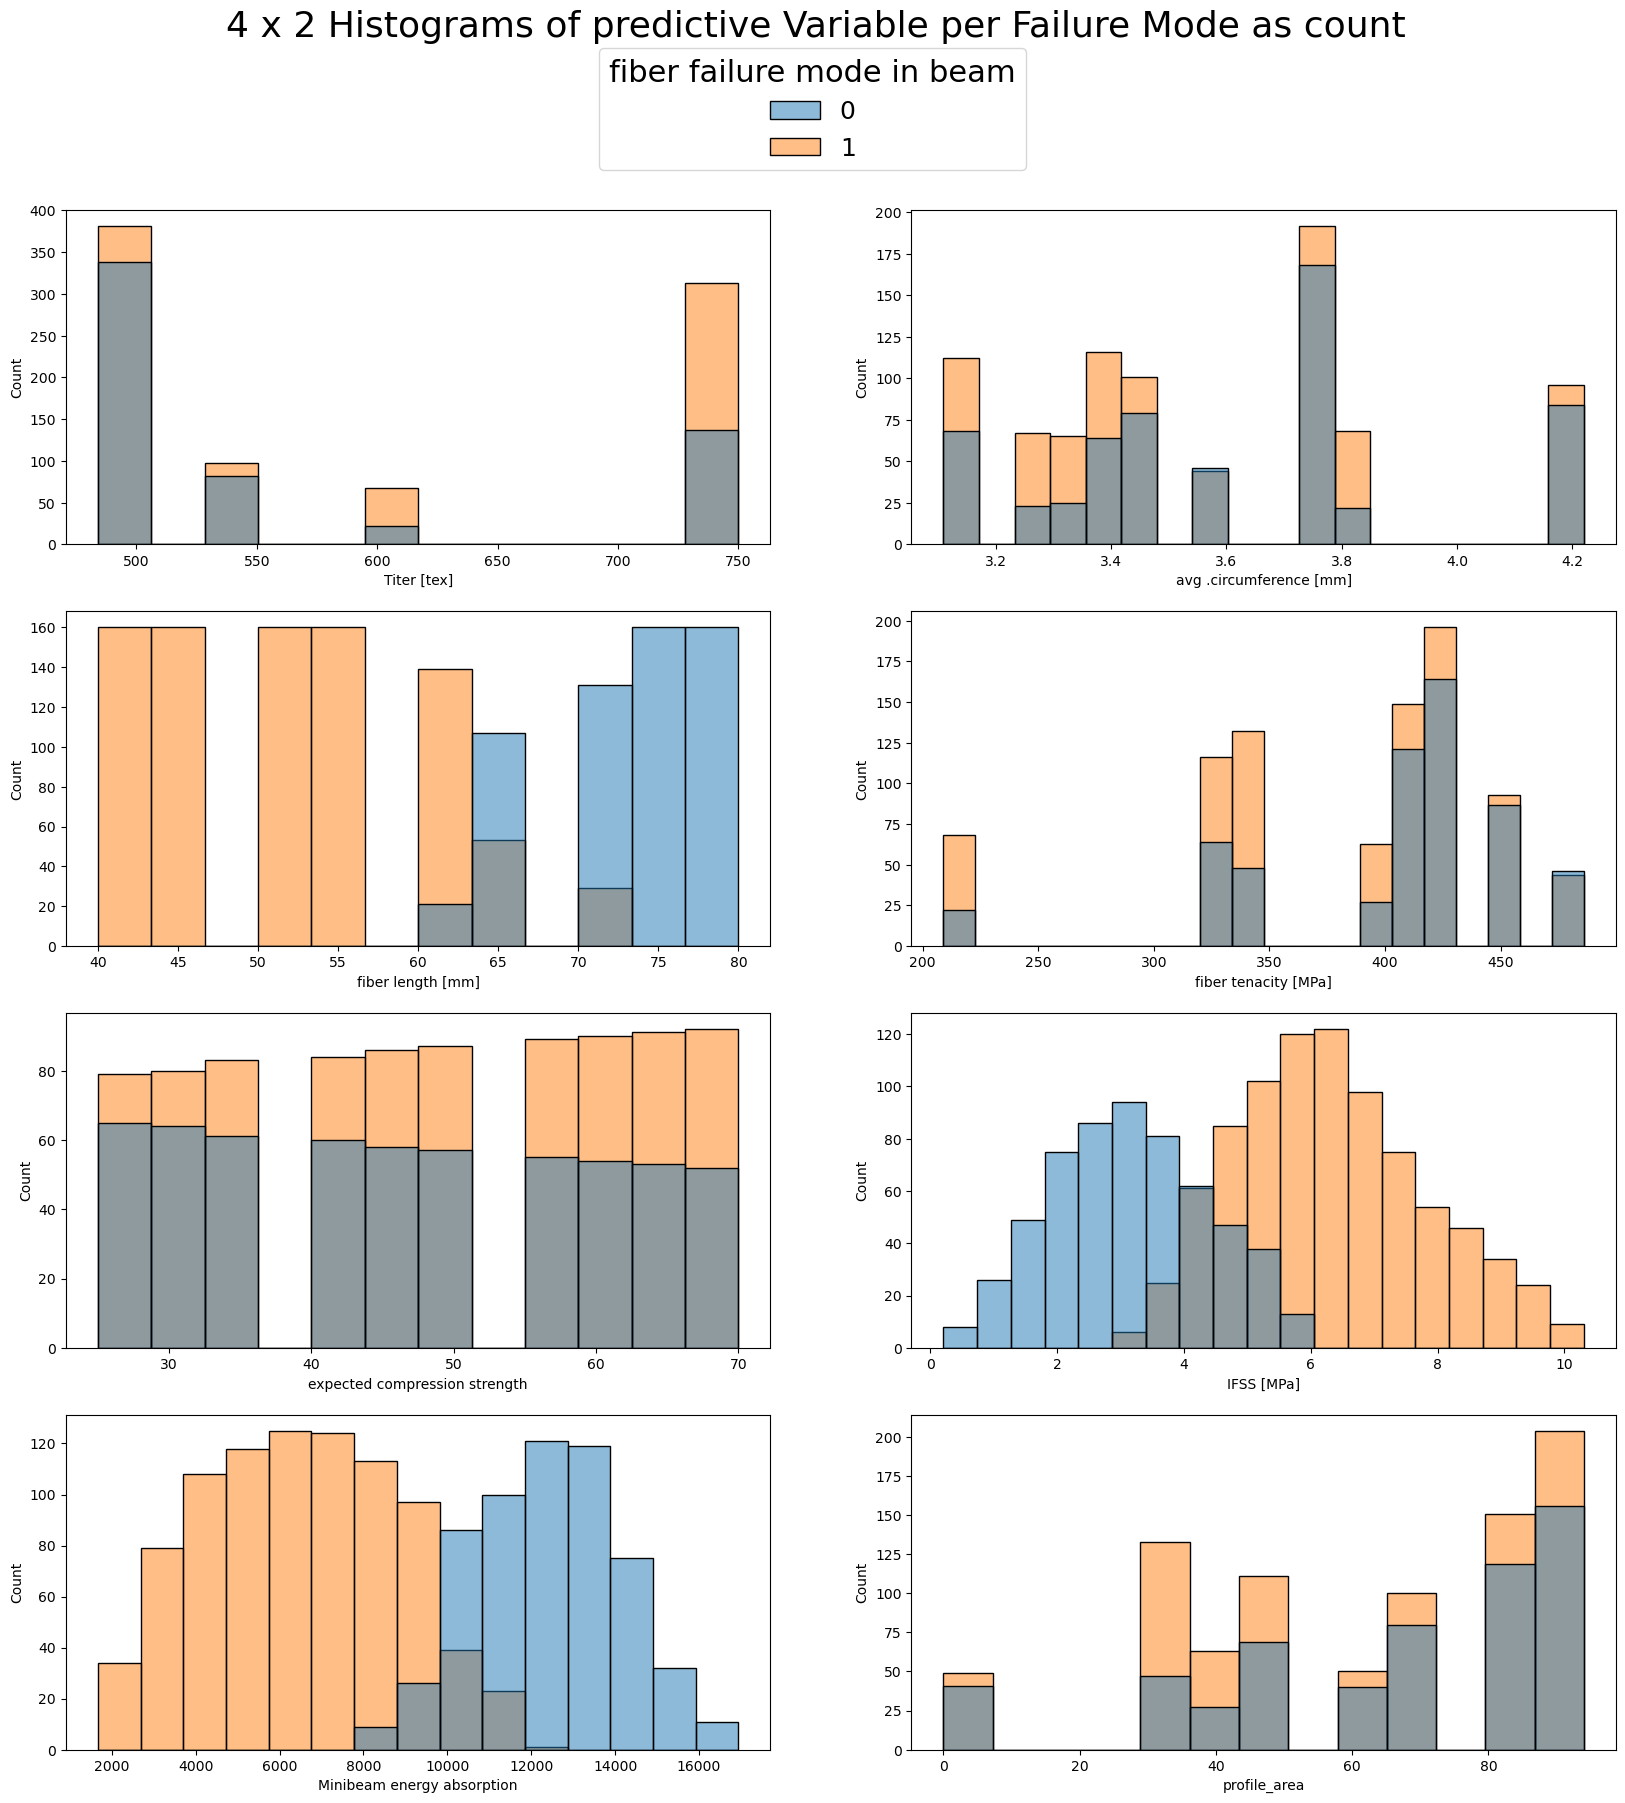

In [105]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

fig.suptitle('4 x 2 Histograms of predictive Variable per Failure Mode as count', fontsize = 26)

ob = sns.histplot(ax = axes[0,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "Titer [tex]", legend = True)
sns.histplot(ax = axes[0,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "avg .circumference [mm]", legend = False)
sns.histplot(ax = axes[1,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "fiber length [mm]", legend = False)
sns.histplot(ax = axes[1,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "fiber tenacity [MPa]", legend = False)
sns.histplot(ax = axes[2,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "expected compression strength", legend = False)
sns.histplot(ax = axes[2,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "IFSS [MPa]", legend = False)
sns.histplot(ax = axes[3,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "Minibeam energy absorption", legend = False)
sns.histplot(ax = axes[3,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "profile_area", legend = False)
sns.move_legend(bbox_to_anchor=(1.06, 1.3), loc='center', borderaxespad=0, obj = ob, fontsize = 18, title_fontsize = 22)

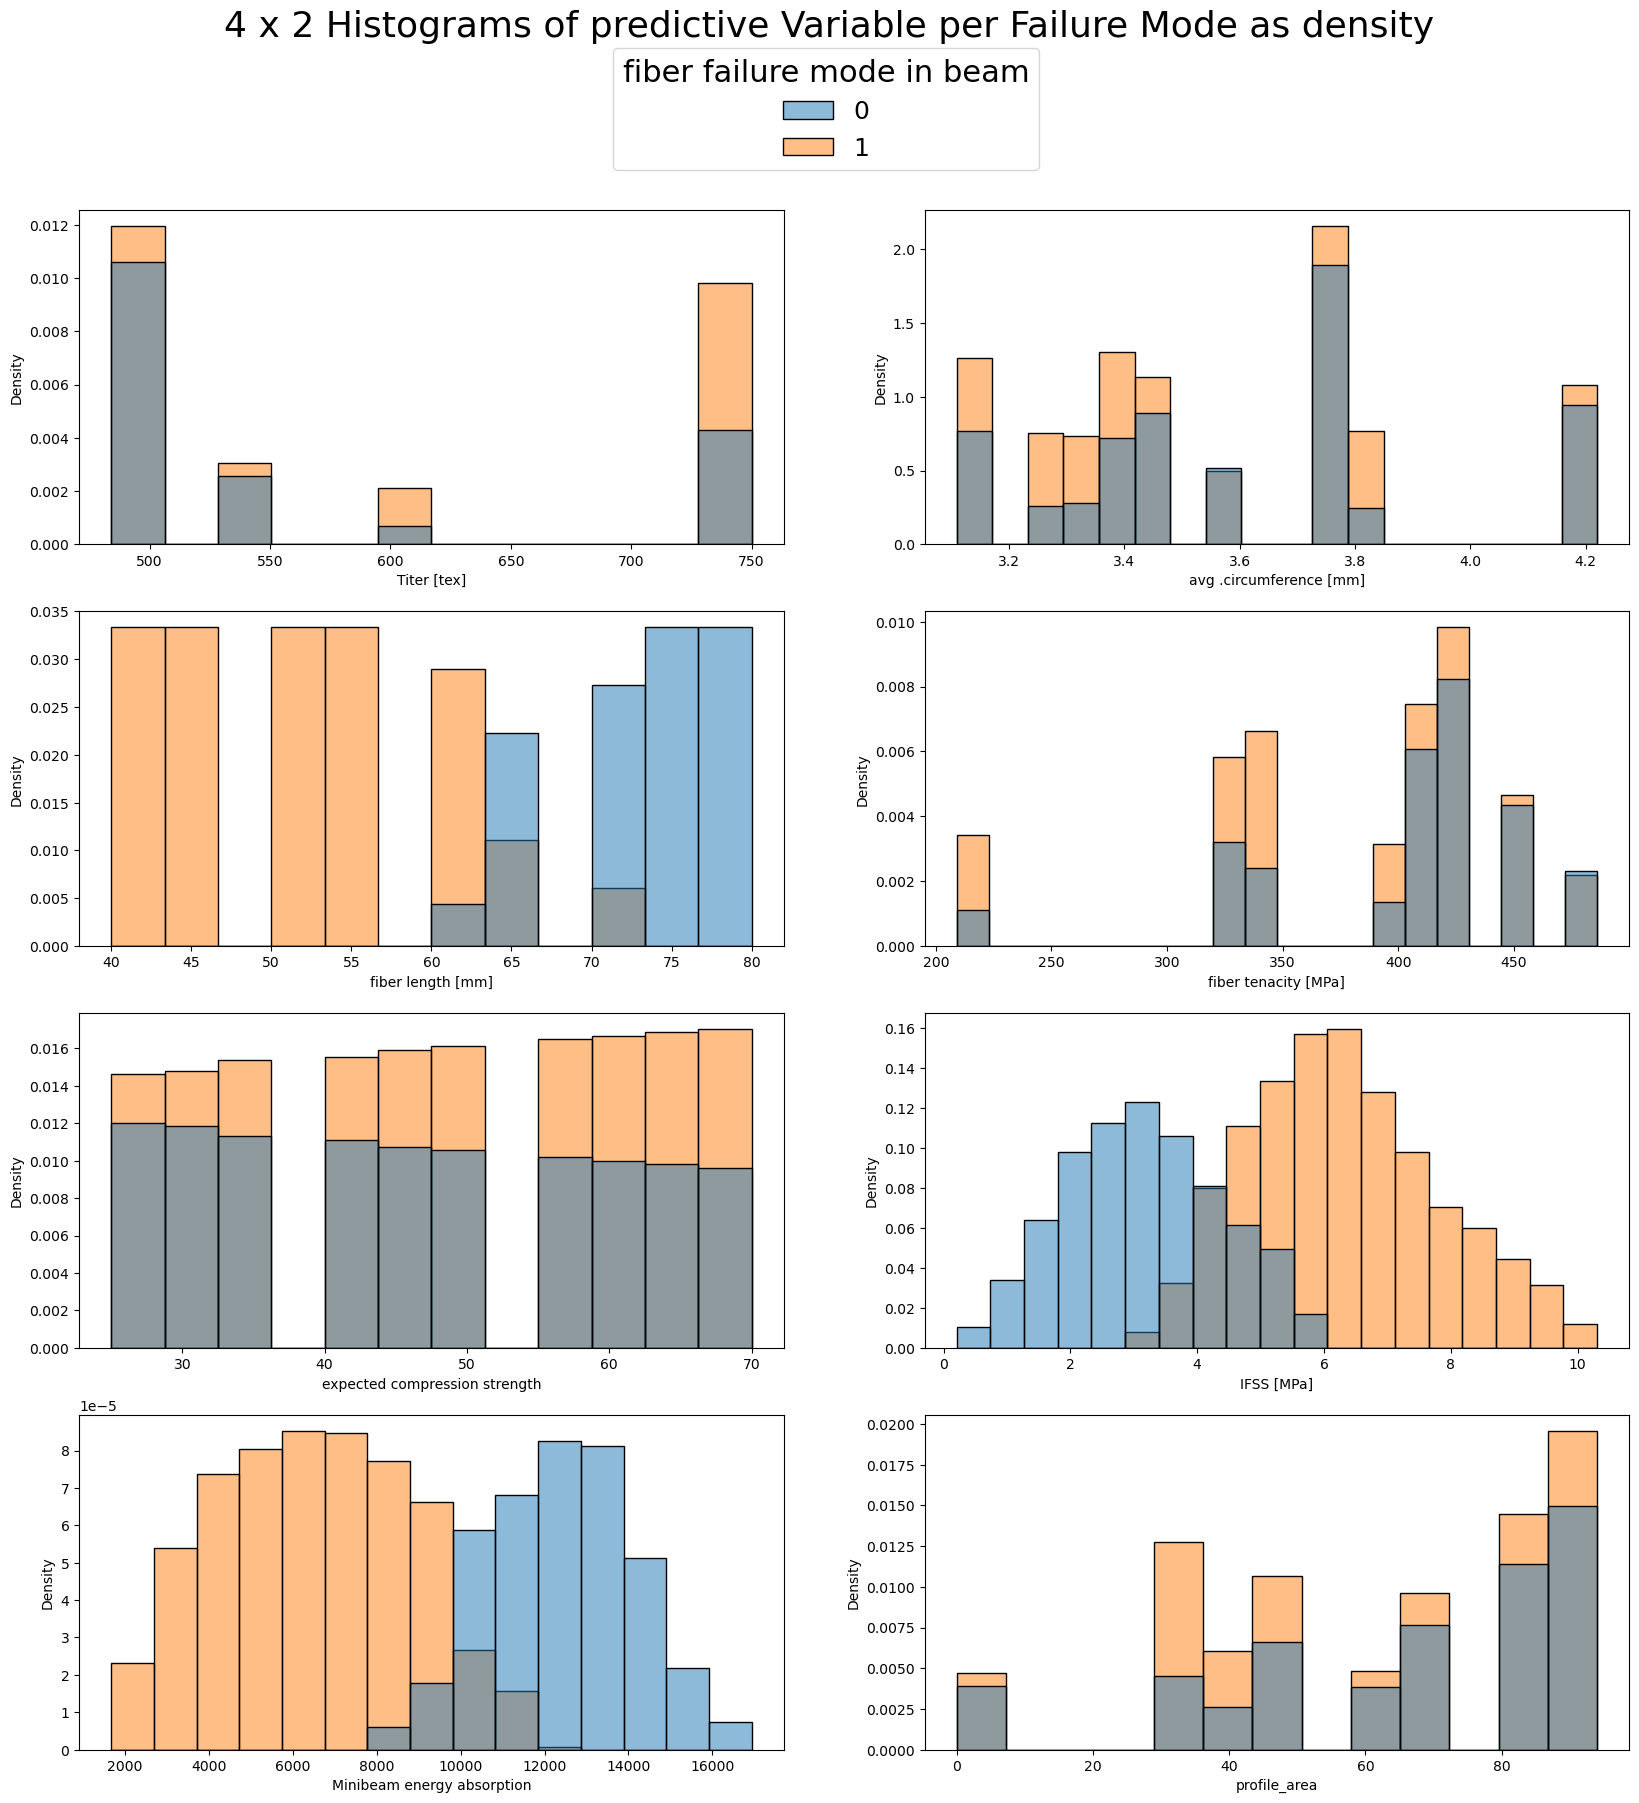

In [81]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

fig.suptitle('4 x 2 Histograms of predictive Variable per Failure Mode as density', fontsize = 26)

ob = sns.histplot(ax = axes[0,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "Titer [tex]", legend = True, stat = "density")
sns.histplot(ax = axes[0,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "avg .circumference [mm]", legend = False, stat = "density")
sns.histplot(ax = axes[1,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "fiber length [mm]", legend = False, stat = "density")
sns.histplot(ax = axes[1,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "fiber tenacity [MPa]", legend = False, stat = "density")
sns.histplot(ax = axes[2,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "expected compression strength", legend = False, stat = "density")
sns.histplot(ax = axes[2,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "IFSS [MPa]", legend = False, stat = "density")
sns.histplot(ax = axes[3,0], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "Minibeam energy absorption", legend = False, stat = "density")
sns.histplot(ax = axes[3,1], data = df_full_data_extended_hist, hue = "fiber failure mode in beam", x = "profile_area", legend = False, stat = "density")
sns.move_legend(bbox_to_anchor=(1.06, 1.3), loc='center', borderaxespad=0, obj = ob, fontsize = 18, title_fontsize = 22)

We can identify some patterns within the histograms. A relative clear distinction can be made for interfacial sheer strength, where a higher IFSS is associated with failure mode 1. A similar connection can be made for fiber length, where a higher fiber length is associated with failure mode 1. The reverse relation appears true for the Minibeam energy absorption where a higher absorption is associated with failure mode 0.

<Axes: xlabel='fiber failure mode in beam', ylabel='profile_area'>

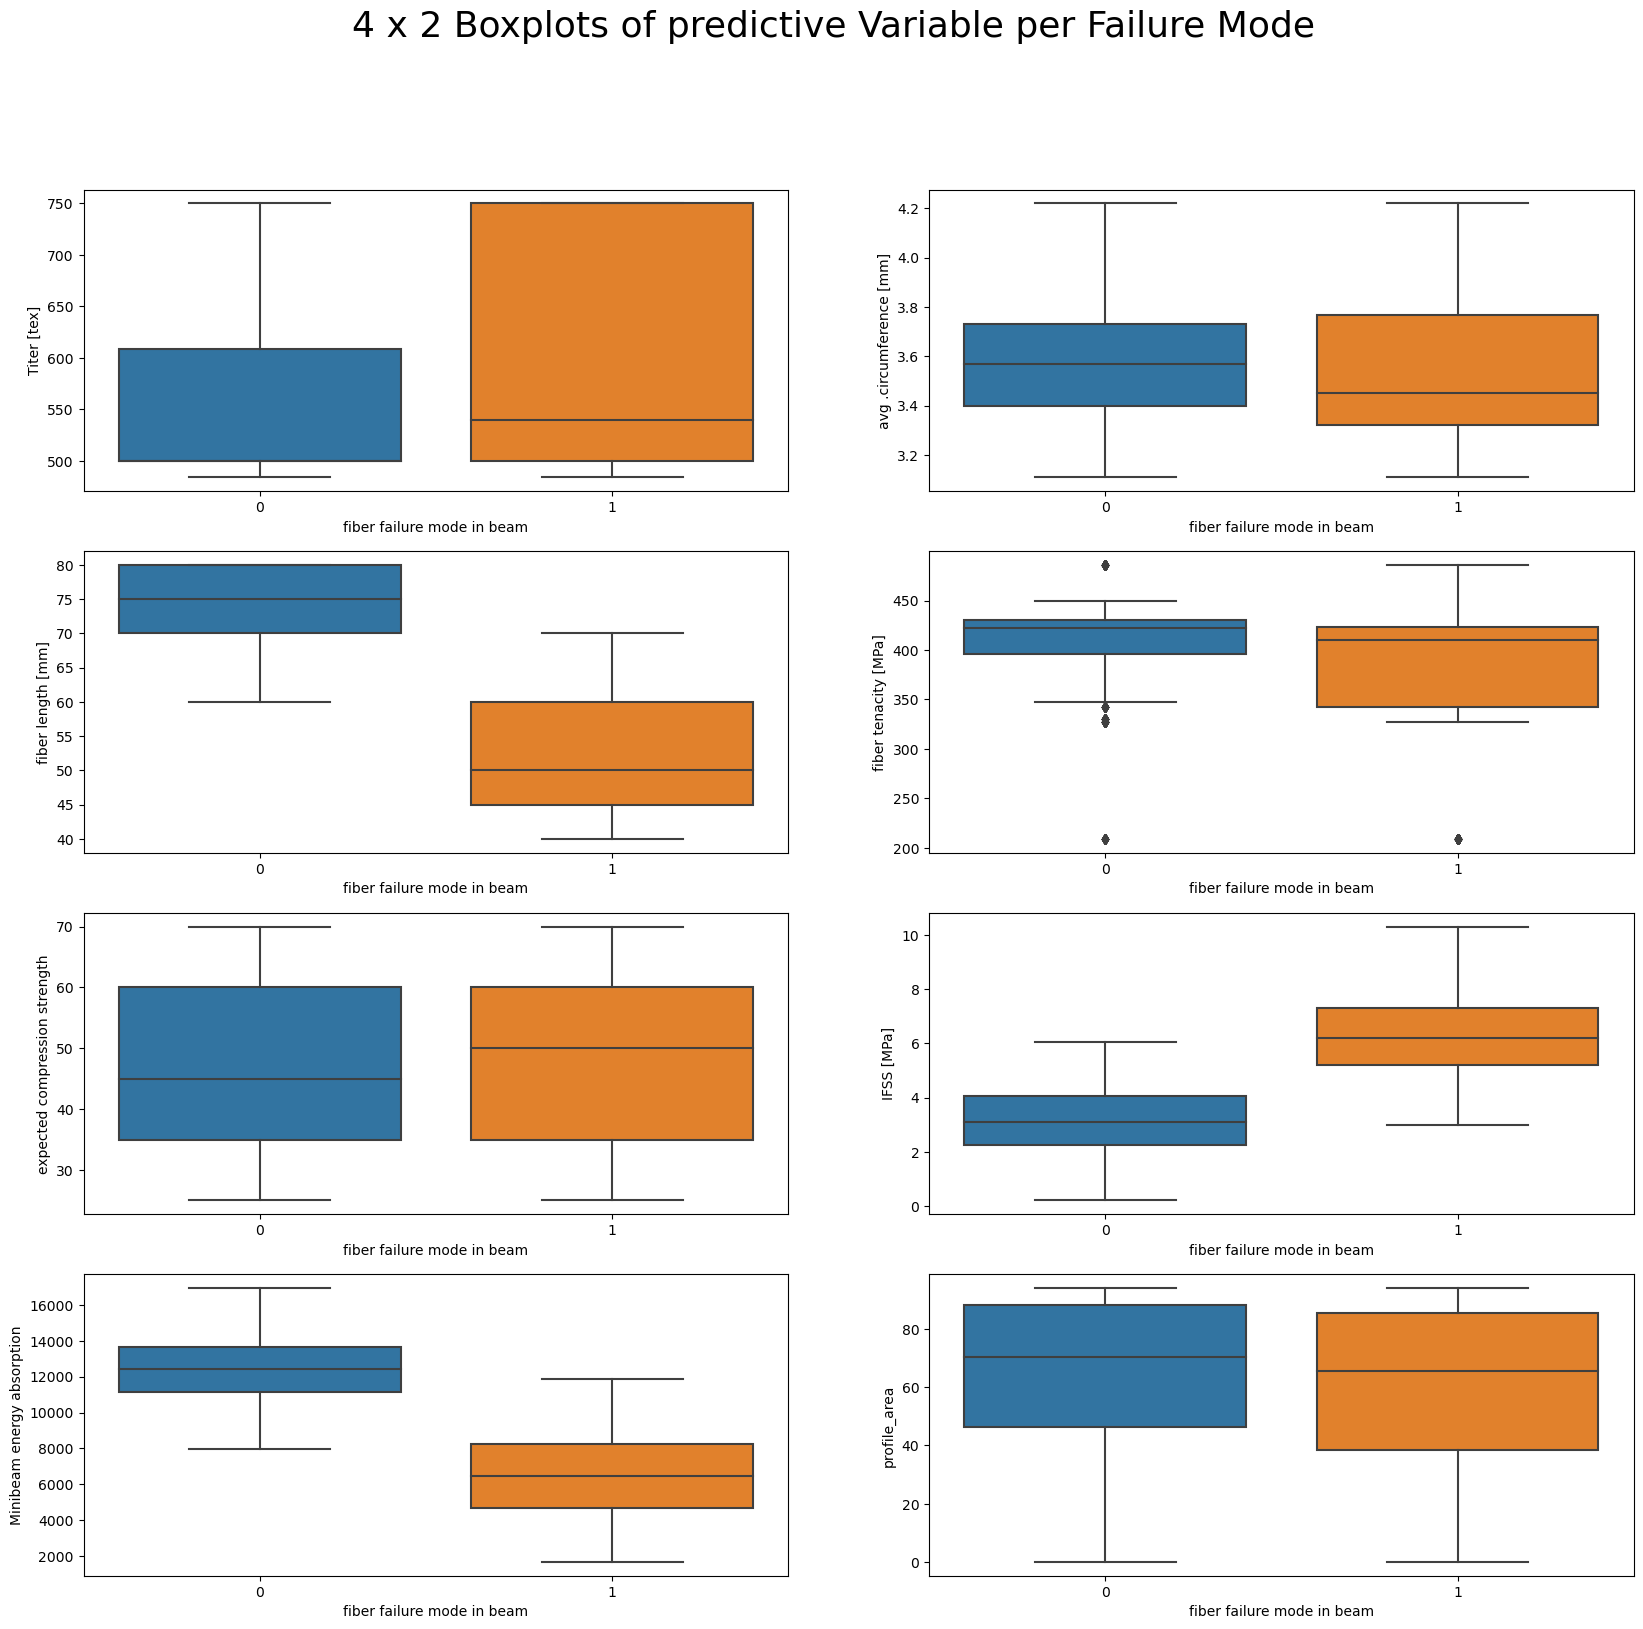

In [108]:
fig, axes = plt.subplots(4, 2, figsize=(20, 18))

fig.suptitle('4 x 2 Boxplots of predictive Variable per Failure Mode', fontsize = 26)

sns.boxplot(ax = axes[0,0], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "Titer [tex]")
sns.boxplot(ax = axes[0,1], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "avg .circumference [mm]")
sns.boxplot(ax = axes[1,0], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "fiber length [mm]")
sns.boxplot(ax = axes[1,1], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "fiber tenacity [MPa]")
sns.boxplot(ax = axes[2,0], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "expected compression strength")
sns.boxplot(ax = axes[2,1], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "IFSS [MPa]")
sns.boxplot(ax = axes[3,0], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "Minibeam energy absorption")
sns.boxplot(ax = axes[3,1], data = df_full_data_extended_hist, x = "fiber failure mode in beam", y = "profile_area")

The boxplots further support the assumption that fiber length and Minibeam energy absorption are important predictors for the failure mode, considering that the IQR of both are outside of the mean within group. 

E:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


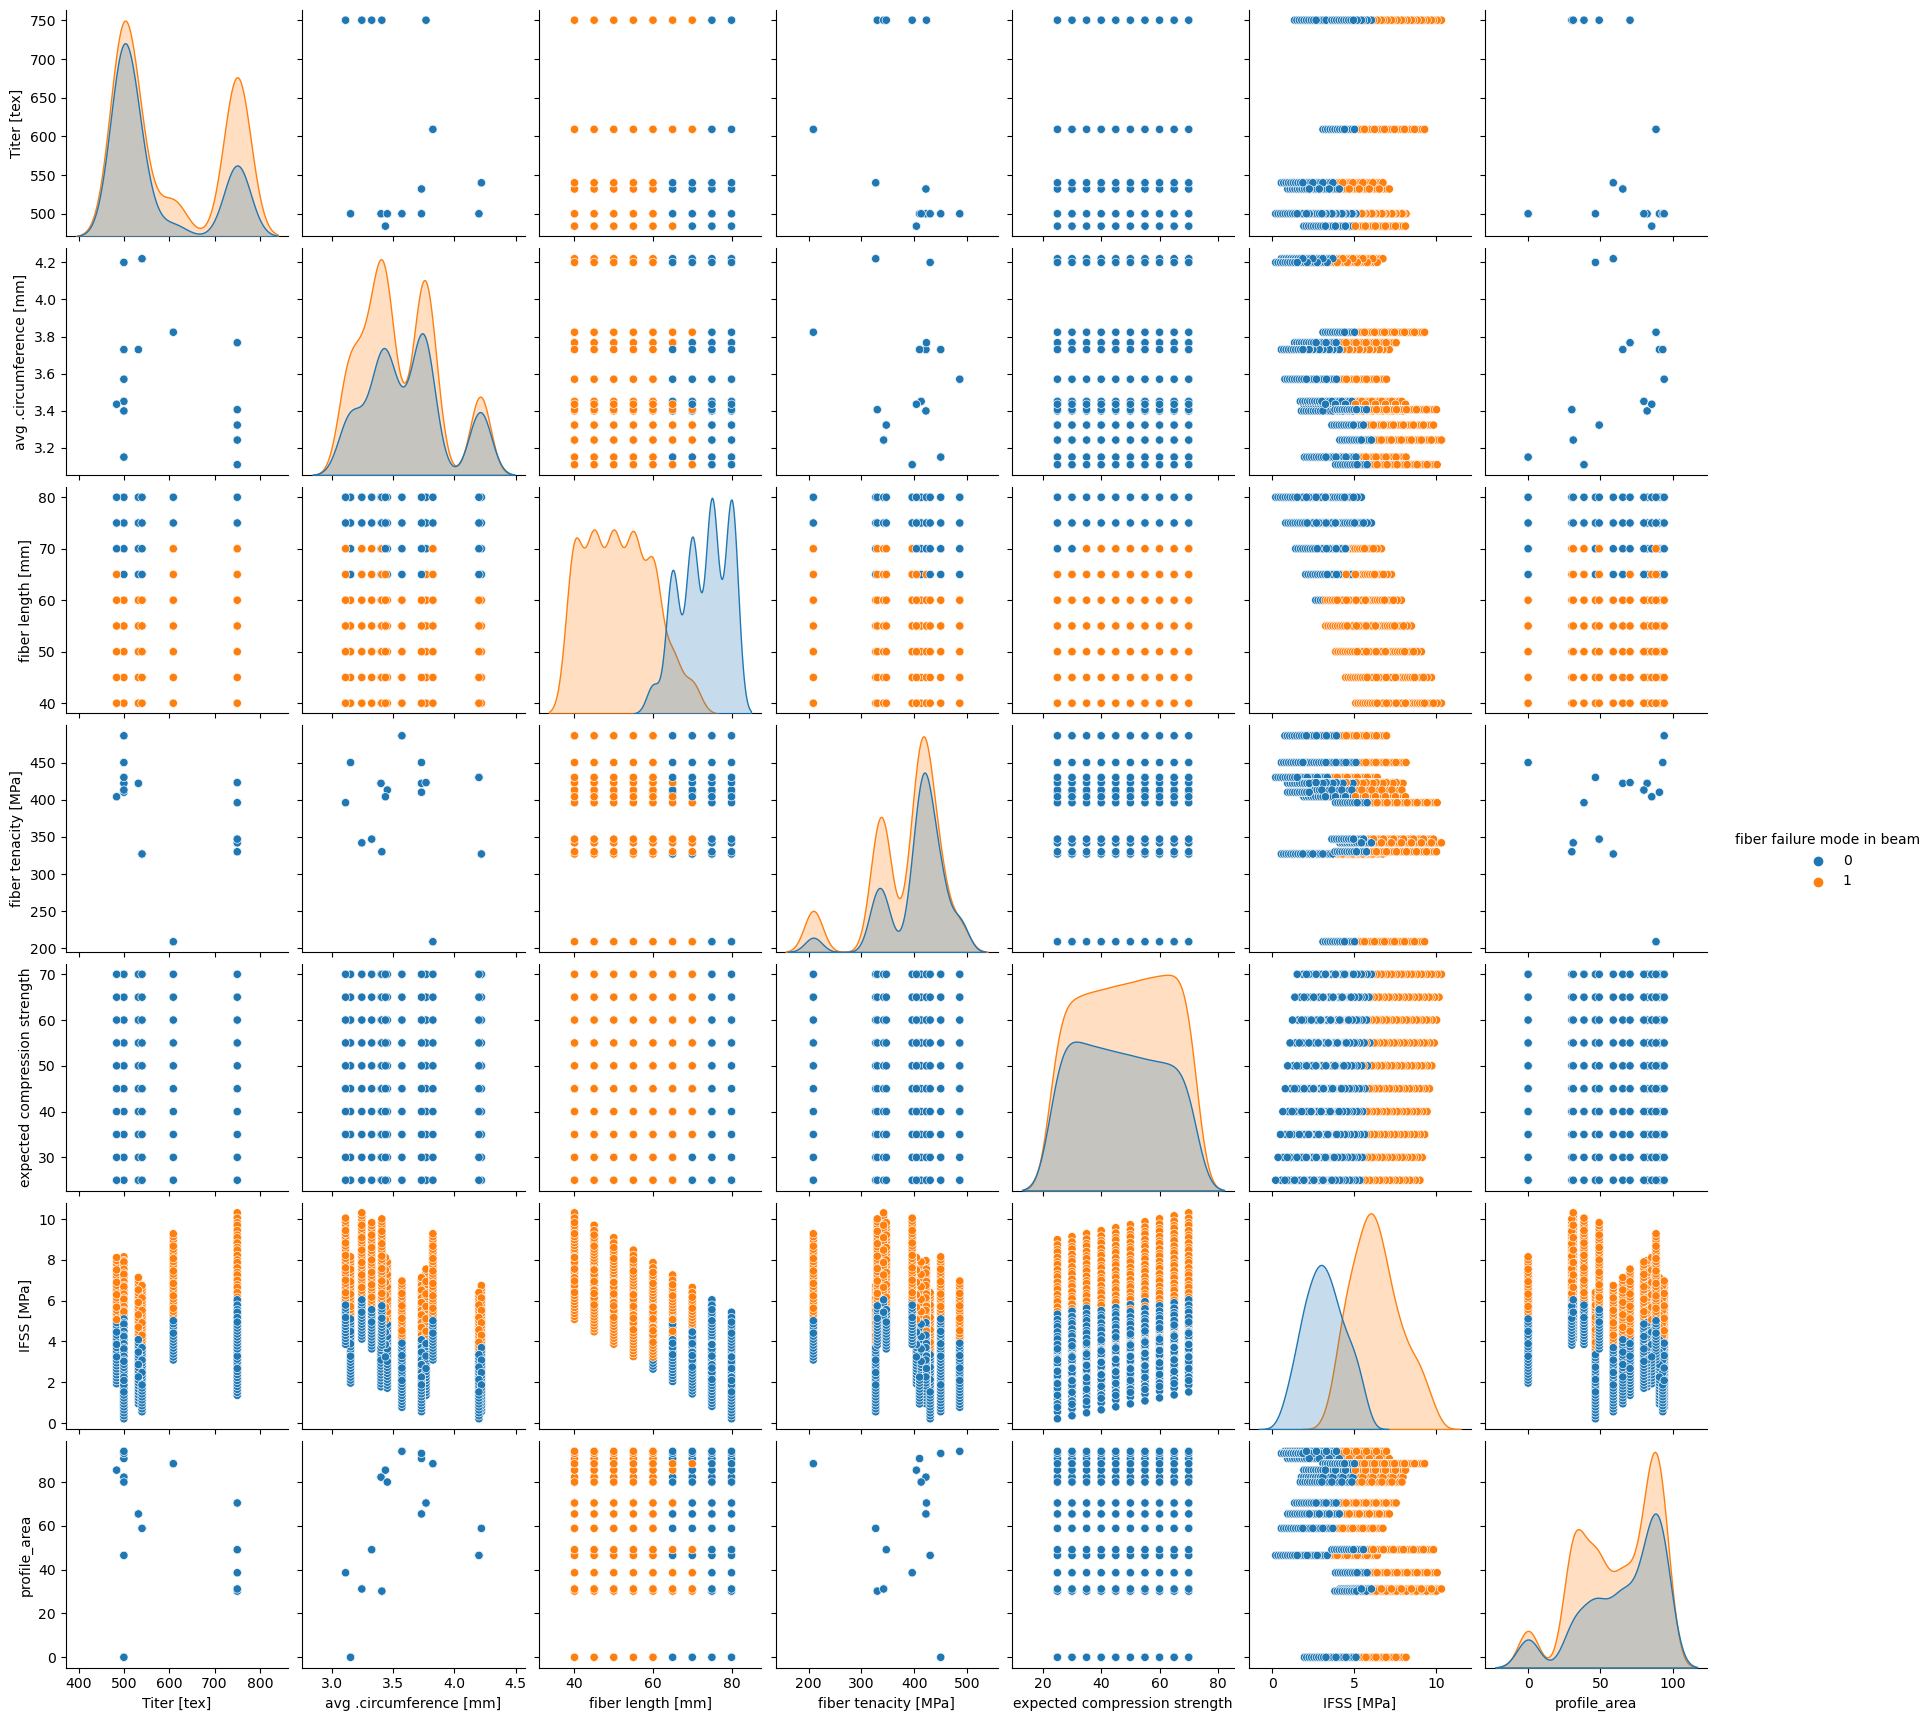

In [71]:
sns.pairplot(df_full_data_extended_hist, vars = df_full_data_extended_hist.columns[[0,1,2,3,6,7,10]], hue = 'fiber failure mode in beam')

Lets do some PCA :)

In [88]:
df_no_outcome = df_full_data_extended.drop(["fiber failure mode in beam","profile_area"], axis= "columns")
pca = PCA(n_components = 2)
pca_comp = pca.fit_transform(df_no_outcome)
pca_df = pd.DataFrame(data=pca_comp, columns=['PC1', 'PC2'])

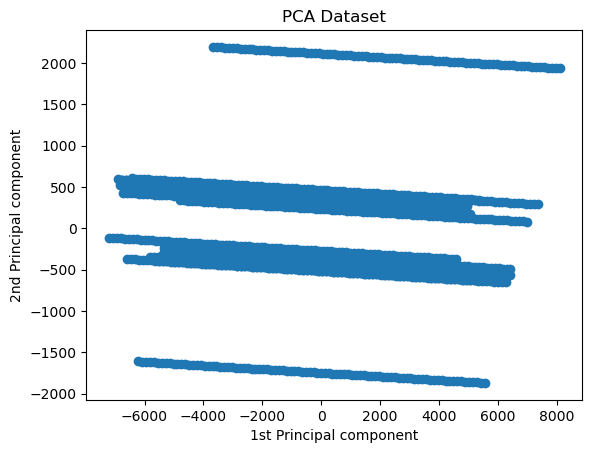

In [89]:
plt.scatter(pca_df["PC1"], pca_df["PC2"])
plt.xlabel("1st Principal component")
plt.ylabel("2nd Principal component")
plt.title("PCA Dataset")
plt.show()

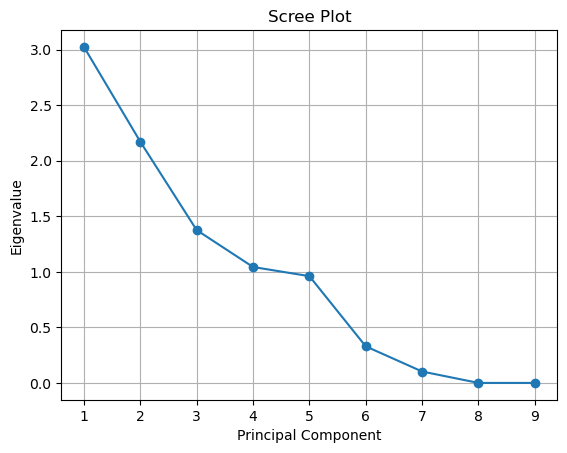

In [90]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_no_outcome)
pca = PCA()
pca.fit(df_scaled)
explained_variance = pca.explained_variance_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot - w/o Profile Area')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

A naive first PCA, trying to reduce the dimensionality down to 2 is rather unsatisfactory. The screeplot reveals that, following the fule of thumb, we should use the first 5 principal components. A nice graphical visualization of a five dimensional space however is impossible. 

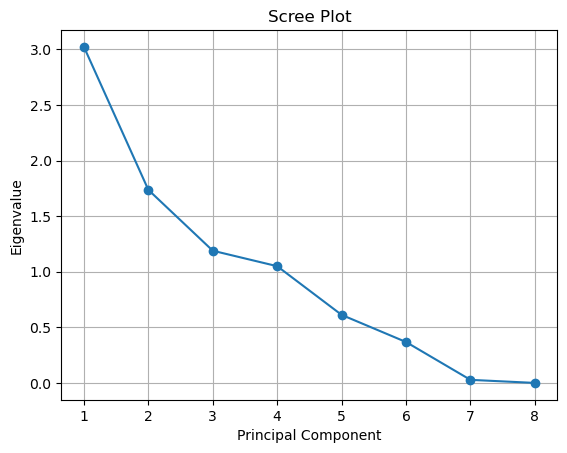

In [91]:
df_no_outcome_2 = df_full_data_extended.drop(["fiber failure mode in beam","W_q [µm]","W_Sm [µm]"], axis= "columns")
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_no_outcome_2)
pca = PCA()
pca.fit(df_scaled)
explained_variance = pca.explained_variance_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Scree Plot - w/ Profile area')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

By introducing the profile area, we can similarly achieve a dimensionality reduction, where by the rule of thumb indicates
that four principal components should be utilized.